In [1]:
#Importing all required library
import nltk
import re
import string
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS
import transformers
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

In [2]:
#Downloading nltk StopWords and Wordnet
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Dataset1
1.importing 1st dataset
2.EDA on 1st dataset
3.Data pre-processing

In [3]:
Dataset1 = pd.read_csv("/content/news.csv")

In [4]:
Dataset1.head()

Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL

In [5]:
Dataset1.tail()

Unnamed: 0                                              title  \
6330        4490  State Department says it can't find emails fro...   
6331        8062  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
6332        8622  Anti-Trump Protesters Are Tools of the Oligarc...   
6333        4021  In Ethiopia, Obama seeks progress on peace, se...   
6334        4330  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                   text label  
6330  The State Department told the Republican Natio...  REAL  
6331  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...  FAKE  
6332   Anti-Trump Protesters Are Tools of the Oligar...  FAKE  
6333  ADDIS ABABA, Ethiopia —President Obama convene...  REAL  
6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...  REAL

In [6]:
Dataset1.nunique()

Unnamed: 0    6335
title         6256
text          6060
label            2
dtype: int64

In [7]:
Dataset1["Article"] = Dataset1["title"] + Dataset1["text"]
Dataset1.sample(frac = 1) #Shuffle 100%

Dataset1.label[Dataset1.label == 'REAL'] = 1
Dataset1.label[Dataset1.label == 'FAKE'] = 0

Dataset1 = Dataset1.loc[:,['Article','label']]
Dataset1 = Dataset1.dropna()

<ipython-input-7-586347da7020>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Dataset1.label[Dataset1.label == 'REAL'] = 1
<ipython-input-7-586347da7020>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In this step we will clean the data that will be used for training. The cleaning will involve these steps-
1.Removing all the extra information like brackets, any kind of puctuations - commas, apostrophes, quotes, question marks, and more.
2.Remove all the numeric text, urls

In [8]:
def wordpre(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [9]:
def bert_encode(texts, tokenizer, max_len=512):
    # ... (code from the previous answer) ...
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

max_len = 256  # Adjust based on your data

In [10]:
import numpy as np
from transformers import BertTokenizer, TFBertModel

def bert_encode(texts, tokenizer, max_len=512):
    """
    Tokenizes and encodes text data for BERT.

    Args:
        texts: A list of strings to encode.
        tokenizer: A pre-trained BERT tokenizer.
        max_len: The maximum sequence length.

    Returns:
        A tuple of NumPy arrays: (input_ids, attention_masks, token_type_ids).
    """
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)
        text = text[:max_len - 2]  # Leave space for [CLS] and [SEP]

        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# Example Usage (assuming Dataset1, tokenizer, and max_len are defined elsewhere)
# Make sure that you load Dataset1 before executing this
# Make sure that you set your max_len
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

max_len = 256  # Define this somewhere before the `bert_encode` call

train_text = Dataset1['Article'].values
train_labels = Dataset1['label'].values  # Make sure this is numeric (0 and 1)
train_input = bert_encode(train_text, tokenizer, max_len=max_len)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
def create_model(bert_model, max_len=512):
    # ... (code from the previous answer) ...
    return model

In [12]:
import tensorflow as tf
from transformers import TFBertModel

def create_model(bert_model, max_len=512):
    """
    Creates a BERT-based model for binary classification.

    Args:
        bert_model: A pre-trained TFBertModel.
        max_len: The maximum sequence length.

    Returns:
        A compiled Keras model.
    """
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    input_masks = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_masks')
    input_segments = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_segments')

    bert_output = bert_model([input_ids, input_masks, input_segments])[0]  # Use [0] for the last hidden state
    cls_token = bert_output[:, 0, :] #get the [CLS] token

    # Add a dense layer for classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)  # Sigmoid for binary classification

    model = tf.keras.models.Model(inputs=[input_ids, input_masks, input_segments], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy']) #Adam is a good choice
    return model

# Example Usage (assuming bert_model and max_len are defined elsewhere)
# Load the tokenizer and BERT model (ensure this is done before calling create_model)
from transformers import BertTokenizer, TFBertModel
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

max_len = 256  # Or whatever length you choose

model = create_model(bert_model, max_len=max_len)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 input_masks (InputLayer)    [(None, 256)]                0         []                            
                                                                                                  
 input_segments (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',       

In [ ]:
#Importing all required library
import nltk
import re
import string
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS
#For BERT
import transformers
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

#Downloading nltk StopWords and Wordnet
nltk.download('stopwords')
nltk.download('wordnet')


# Dataset1
# 1.importing 1st dataset
# 2.EDA on 1st dataset
# 3.Data pre-processing
Dataset1 = pd.read_csv("/content/news.csv")

# Create 'Article' column *first*
Dataset1["Article"] = Dataset1["title"] + Dataset1["text"]

# Assign numerical labels using .loc to avoid SettingWithCopyWarning
Dataset1.loc[Dataset1.label == 'REAL', 'label'] = 1
Dataset1.loc[Dataset1.label == 'FAKE', 'label'] = 0

# Drop rows with missing values *after* assigning numerical labels
Dataset1 = Dataset1.loc[:,['Article','label']].dropna()

#Check if label dtypes are object or int:
print(Dataset1['label'].dtypes)
#Check the dataset shapes
print(Dataset1.shape)
# In this step we will clean the data that will be used for training. The cleaning will involve these steps-
# 1.Removing all the extra information like brackets, any kind of puctuations - commas, apostrophes, quotes, question marks, and more.
# 2.Remove all the numeric text, urls
def wordpre(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text
##  Applying the wordpre method to the dataset
Dataset1['Article']=Dataset1['Article'].apply(wordpre)

train_text = Dataset1['Article'].values
train_labels = Dataset1['label'].values  # Make sure this is numeric (0 and 1)
#BERT Implementation

# 1. Load pre-trained BERT model and tokenizer
bert_model_name = 'bert-base-uncased'  # You can use other BERT variants
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

# 2. Tokenize the text data
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# Define max length (important for BERT)
max_len = 256  # Adjust based on your data, but shorter is faster.  BERT has a limit of 512.

# Apply tokenization
train_input = bert_encode(train_text, tokenizer, max_len=max_len)
# 3. Create the BERT model
def create_model(bert_model, max_len=512):
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    input_masks = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_masks')
    input_segments = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_segments')

    bert_output = bert_model([input_ids, input_masks, input_segments])[0]  # Use [0] for the last hidden state
    cls_token = bert_output[:, 0, :] #get the [CLS] token

    # Add a dense layer for classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(cls_token)  # Sigmoid for binary classification

    model = tf.keras.models.Model(inputs=[input_ids, input_masks, input_segments], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy']) #Adam is a good choice
    return model

model = create_model(bert_model, max_len=max_len)
model.summary() #Print model summary to inspect the architecture

#4. Split Data into Train/Validation
print("Shape of train_input:", type(train_input))
if isinstance(train_input, tuple):
  print("Shape of train_input[0]:", train_input[0].shape)  # Input IDs
  print("Shape of train_input[1]:", train_input[1].shape)  # Attention Masks
  print("Shape of train_input[2]:", train_input[2].shape)  # Token Type IDs
print("Shape of train_labels:", train_labels.shape)

train_input_ids, val_input_ids, train_input_masks, val_input_masks, train_input_segments, val_input_segments, train_labels, val_labels = train_test_split(
    train_input[0], train_input[1], train_input[2], train_labels, test_size=0.2, random_state=42
)

train_input_ids = train_input_ids.astype('int32')
val_input_ids = val_input_ids.astype('int32')
train_input_masks = train_input_masks.astype('int32')
val_input_masks = val_input_masks.astype('int32')
train_input_segments = train_input_segments.astype('int32')
val_input_segments = val_input_segments.astype('int32')
train_labels = train_labels.astype('float32') # Use float32 because sigmoid output
val_labels = val_labels.astype('float32')

# 5. Train the model
history = model.fit(
    [train_input_ids, train_input_masks, train_input_segments],
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_input_segments], val_labels),
    epochs=2,  # Start with a small number of epochs to avoid overfitting
    batch_size=32 # Adjust based on your memory
)


# 5. Train the model
history = model.fit(
    [train_input_ids, train_input_masks, train_input_segments],
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_input_segments], val_labels),
    epochs=2,  # Start with a small number of epochs to avoid overfitting
    batch_size=32 # Adjust based on your memory
)

#6. Evaluate the model
loss, accuracy = model.evaluate([val_input_ids, val_input_masks, val_input_segments], val_labels)
print(f"Validation Accuracy: {accuracy}")

predictions = model.predict([val_input_ids, val_input_masks, val_input_segments])
predicted_labels = [1 if p > 0.5 else 0 for p in predictions] #Convert probabilities to labels (0 or 1)
print("Predicted Labels:", predicted_labels)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


object
(6335, 2)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 input_masks (InputLayer)    [(None, 256)]                0         []                            
                                                                                                  
 input_segments (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',     

In [1]:
##  Applying the wordpre method to the dataset
Dataset1['Article']=Dataset1['Article'].apply(wordpre)

NameError: name 'Dataset1' is not defined

In [ ]:
#word used in Real news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset1[Dataset1.label== 1].Article))
plt.imshow(wc, interpolation="bilinear")

In [ ]:
#word used in Fake news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset1[Dataset1.label== 0].Article))
plt.imshow(wc, interpolation="bilinear")

# Dataset2

In [3]:
#Importing all required library
import nltk
import re
import string
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
from wordcloud import WordCloud, STOPWORDS
import transformers
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

In [4]:
Dataset2_true = pd.read_csv("/content/True.csv")
Dataset2_fake = pd.read_csv("/content/Fake.csv")

In [5]:
Dataset2_true.nunique()

title      20826
text       21192
subject        2
date         716
dtype: int64

In [6]:
Dataset2_fake.nunique()

title      17903
text       17455
subject        6
date        1681
dtype: int64

In [10]:
import pandas as pd

# Assuming Dataset2_true is a Pandas DataFrame with a column named 'subject'

# Load your data (replace with your actual data loading code)
# For example:
# Dataset2_true = pd.read_csv("your_data_file.csv")

# Check if the 'subject' column exists
if 'subject' not in Dataset2_true.columns:
    print("Error: 'subject' column not found in Dataset2_true.")
else:
    # Counting by Subjects in Real news
    subject_counts = Dataset2_true['subject'].value_counts() #More concise and readable

    for subject, count in subject_counts.items(): # Use items() to iterate
        print(f"{subject}:\t{count}")

    # Getting Total Rows
    total_records = Dataset2_true.shape[0] #More descriptive variable name
    print(f"Total Records:\t{total_records}")



politicsNews:	11272
worldnews:	10145
Total Records:	21417


AttributeError: 'Series' object has no attribute 'iteritems'

In [11]:
import pandas as pd

# Assuming Dataset2_fake is a Pandas DataFrame with a column named 'subject'

# Load your data (replace with your actual data loading code)
# For example:
# Dataset2_fake = pd.read_csv("your_data_file.csv")

# Check if the 'subject' column exists
if 'subject' not in Dataset2_fake.columns:
    print("Error: 'subject' column not found in Dataset2_fake.")
else:
    # Counting by Subjects in Fake news
    subject_counts = Dataset2_fake['subject'].value_counts() #More concise and readable

    for subject, count in subject_counts.items(): # Use items() to iterate
        print(f"{subject}:\t{count}")

    # Getting Total Rows
    total_records = Dataset2_fake.shape[0] #More descriptive variable name
    print(f"Total Records:\t{total_records}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


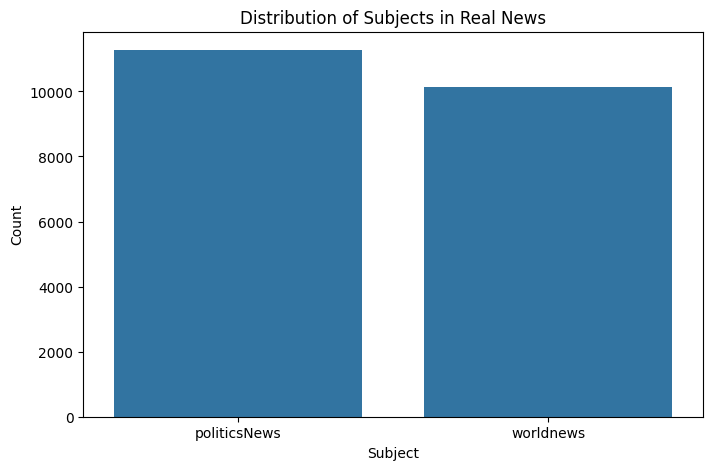

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming Dataset2_true is a Pandas DataFrame with a column named 'subject'

# Load your data (replace with your actual data loading code)
# For example:
# Dataset2_true = pd.read_csv("your_data_file.csv")

# Check if the 'subject' column exists
if 'subject' not in Dataset2_true.columns:
    print("Error: 'subject' column not found in Dataset2_true.")
else:
    # Plotting the Subjects in Real news
    plt.figure(figsize=(8, 5))  # Set figure size before creating the plot
    sns.countplot(x="subject", data=Dataset2_true) #Correct form for countplot. X axis will be "Subject".
    plt.title("Distribution of Subjects in Real News") #Added title
    plt.xlabel("Subject") #Label axis
    plt.ylabel("Count") # Label axis
    plt.show()

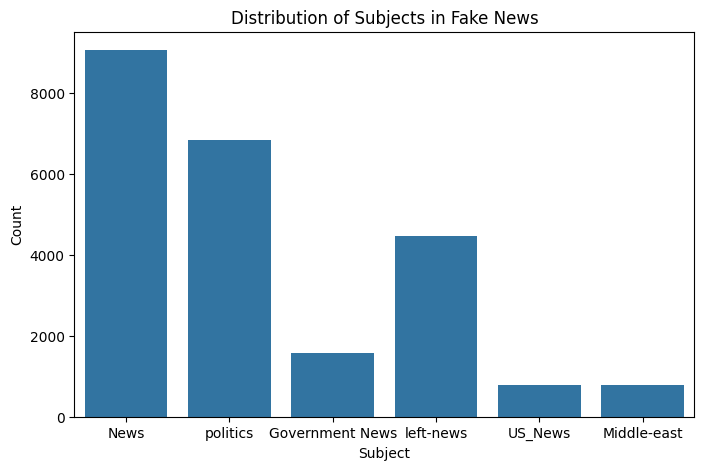

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming Dataset2_fake is a Pandas DataFrame with a column named 'subject'

# Load your data (replace with your actual data loading code)
# For example:
# Dataset2_fake = pd.read_csv("your_data_file.csv")

# Check if the 'subject' column exists
if 'subject' not in Dataset2_fake.columns:
    print("Error: 'subject' column not found in Dataset2_fake.")
else:
    # Plotting the Subjects in Fake news
    plt.figure(figsize=(8, 5))  # Set figure size before creating the plot
    sns.countplot(x="subject", data=Dataset2_fake) #Correct form for countplot. X axis will be "Subject".
    plt.title("Distribution of Subjects in Fake News") #Added title
    plt.xlabel("Subject") #Label axis
    plt.ylabel("Count") # Label axis
    plt.show()

In [16]:
Dataset2_true['label']= 1
Dataset2_fake['label']= 0
Dataset2 = pd.concat([Dataset2_true, Dataset2_fake])
Dataset2["Article"] = Dataset2["title"] + Dataset2["text"]
Dataset2.sample(frac = 1) #Shuffle 100%
Dataset2 = Dataset2.loc[:,['Article','label']]

In [17]:
Dataset2

Article  label
0      As U.S. budget fight looms, Republicans flip t...      1
1      U.S. military to accept transgender recruits o...      1
2      Senior U.S. Republican senator: 'Let Mr. Muell...      1
3      FBI Russia probe helped by Australian diplomat...      1
4      Trump wants Postal Service to charge 'much mor...      1
...                                                  ...    ...
23476  McPain: John McCain Furious That Iran Treated ...      0
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...      0
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...      0
23479  How to Blow $700 Million: Al Jazeera America F...      0
23480  10 U.S. Navy Sailors Held by Iranian Military ...      0

[44898 rows x 2 columns]

In [19]:
##  Applying the wordpre method to the dataset
import re
import string

def wordpre(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text
Dataset2['Article']=Dataset2['Article'].apply(wordpre)

In [20]:
Dataset2.head()

Article  label
0  as u s  budget fight looms  republicans flip t...      1
1  u s  military to accept transgender recruits o...      1
2  senior u s  republican senator   let mr  muell...      1
3  fbi russia probe helped by australian diplomat...      1
4  trump wants postal service to charge  much mor...      1

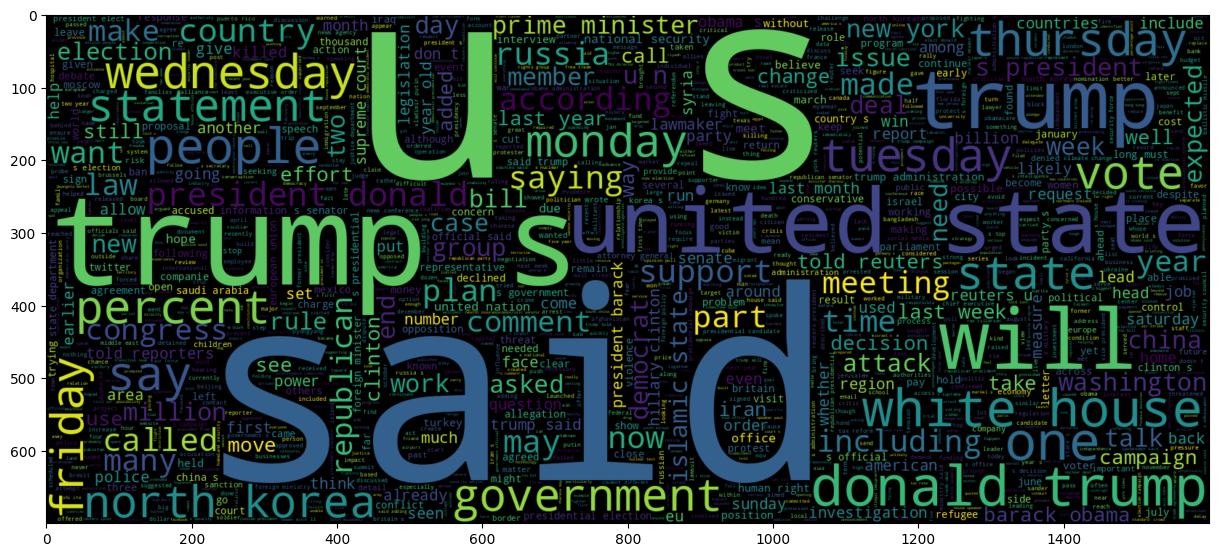

In [21]:
#word used in Real news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset2[Dataset2.label== 1].Article))
plt.imshow(wc, interpolation="bilinear")

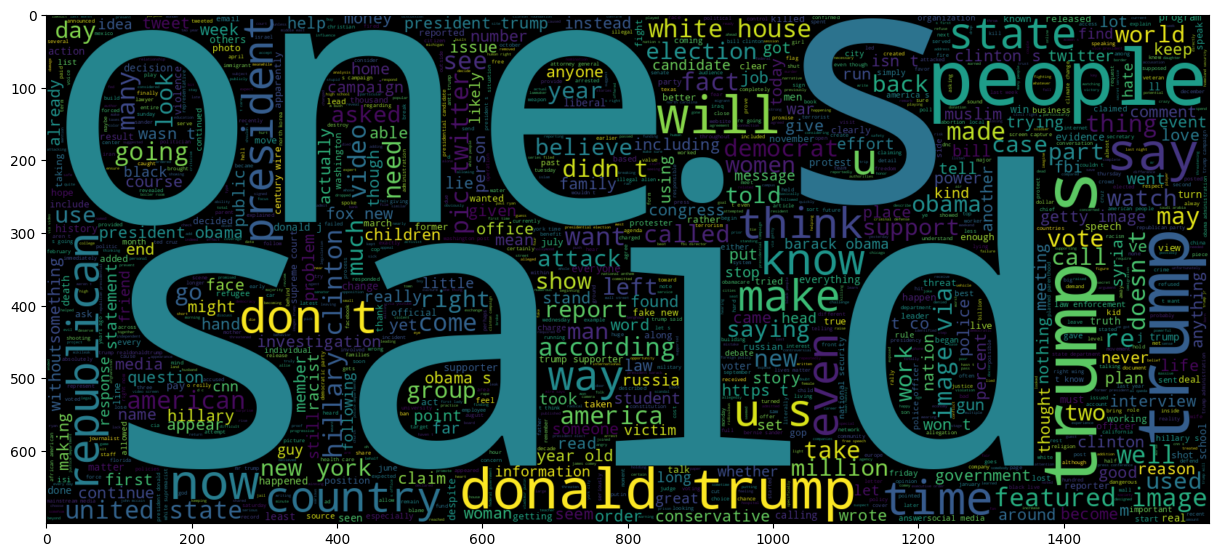

In [22]:
#word used in Fake news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset2[Dataset2.label== 0].Article))
plt.imshow(wc, interpolation="bilinear")

# Dataset 3

In [23]:
Dataset3_real = pd.read_csv("/content/politifact_real.csv")
Dataset3_fake = pd.read_csv("/content/politifact_fake.csv")

In [24]:
Dataset3_real['label']= 1
Dataset3_fake['label']= 0
Dataset3 = pd.concat([Dataset3_real, Dataset3_fake])
Dataset3["Article"] = Dataset3["title"]
Dataset3.sample(frac = 1) #Shuffle 100%
Dataset3 = Dataset3.loc[:,['Article','label']]

In [25]:
Dataset3

Article  label
0          National Federation of Independent Business      1
1                          comments in Fayetteville NC      1
2    Romney makes pitch, hoping to close deal : Ele...      1
3    Democratic Leaders Say House Democrats Are Uni...      1
4      Budget of the United States Government, FY 2008      1
..                                                 ...    ...
427        Who is affected by the government shutdown?      0
428  Lindsey Graham Threatens To Convert To Democra...      0
429  ELECTORAL COLLEGE ELECTOR COMMITS SUICIDE TO A...      0
430  Sarah Palin Calls To Boycott Mall Of America B...      0
431                                  Account Suspended      0

[1056 rows x 2 columns]

In [26]:
##  Applying the wordpre method to the dataset
Dataset3['Article']=Dataset3['Article'].apply(wordpre)

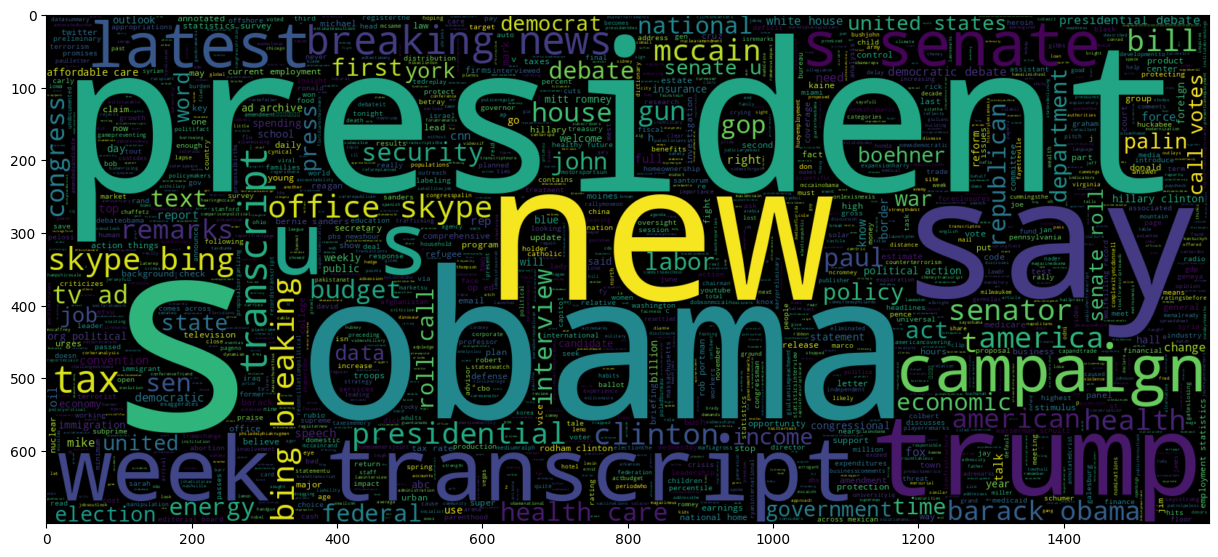

In [27]:
#word used in Real news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset3[Dataset3.label== 1].Article))
plt.imshow(wc, interpolation="bilinear")

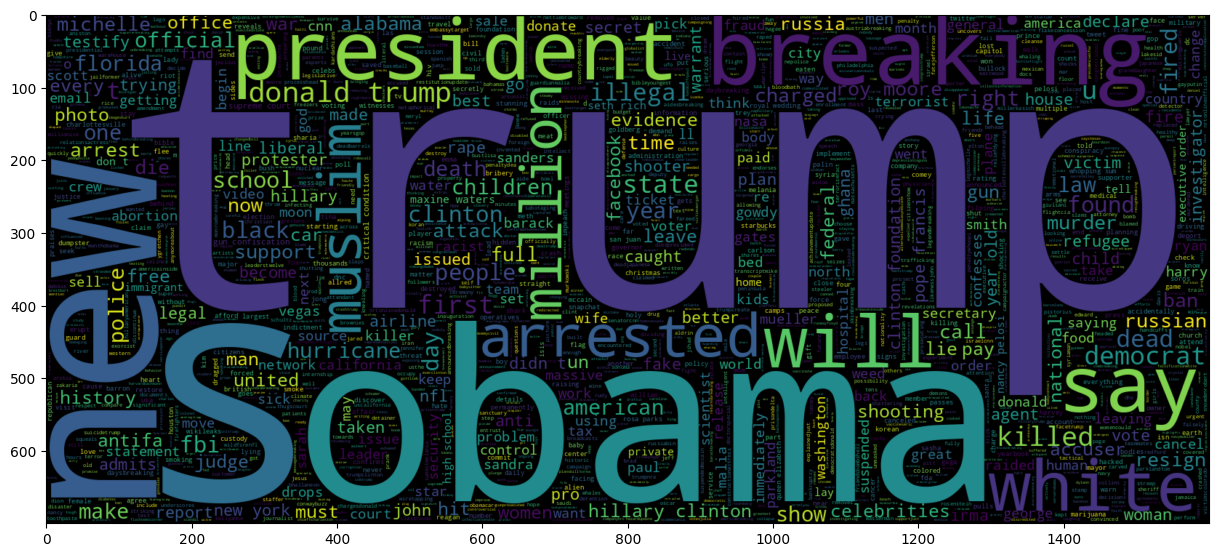

In [28]:
#word used in Fake news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset3[Dataset3.label== 0].Article))
plt.imshow(wc, interpolation="bilinear")

# Dataset 4

In [29]:
Dataset4 = pd.read_csv("/content/train.csv")

In [30]:
Dataset4.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \r\nAn Iranian woman has been sentenced ...      1

In [31]:
Dataset4["Article"] = Dataset4["title"] + Dataset4["text"]
Dataset4.sample(frac = 1) #Shuffle 100%

Dataset4 = Dataset4.loc[:,['Article','label']]
Dataset4 = Dataset4.dropna()

In [32]:
##  Applying the wordpre method to the dataset
Dataset4['Article']=Dataset4['Article'].apply(wordpre)

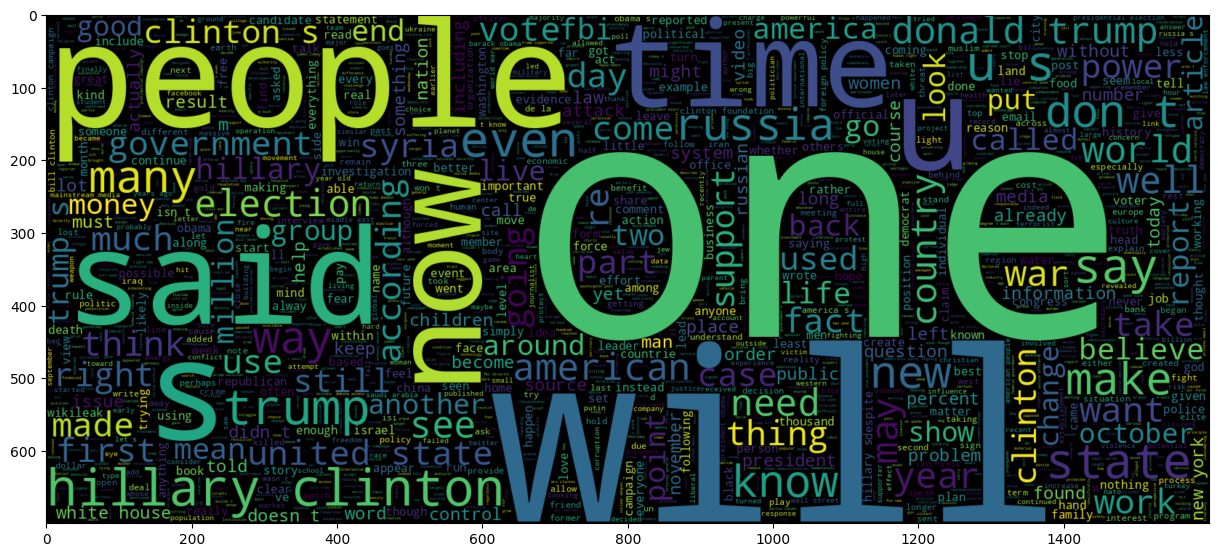

In [33]:
#word used in Real news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset4[Dataset4.label== 1].Article))
plt.imshow(wc, interpolation="bilinear")

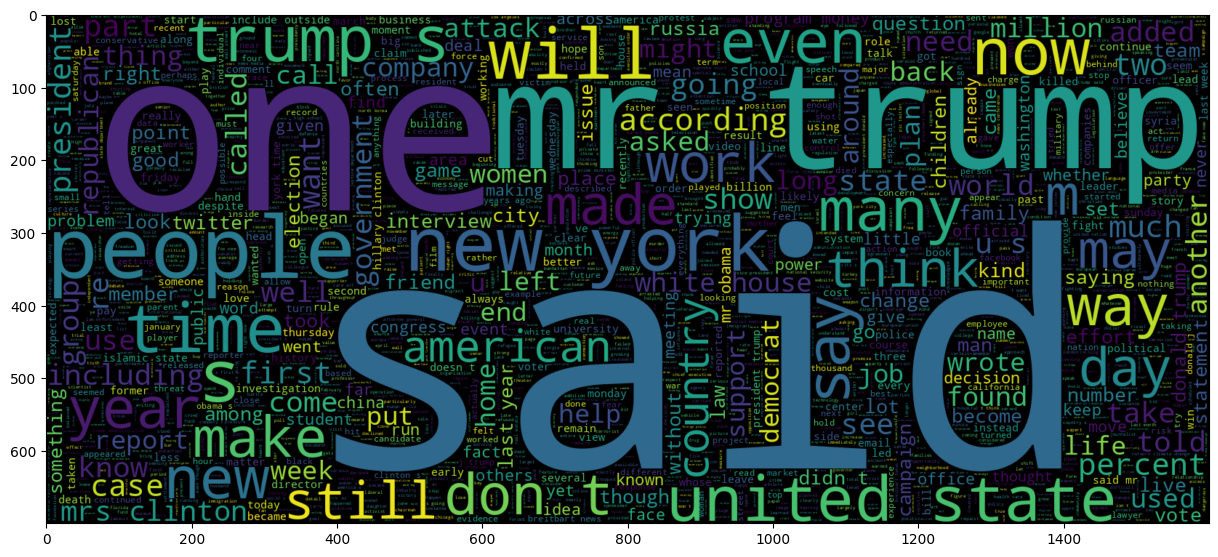

In [34]:
#word used in Fake news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset4[Dataset4.label== 0].Article))
plt.imshow(wc, interpolation="bilinear")

# Dataset 5

In [35]:
Dataset5 = pd.read_csv("/content/data.csv")

In [36]:
Dataset5

URLs  \
0     http://www.bbc.com/news/world-us-canada-414191...   
1     https://www.reuters.com/article/us-filmfestiva...   
2     https://www.nytimes.com/2017/10/09/us/politics...   
3     https://www.reuters.com/article/us-mexico-oil-...   
4     http://www.cnn.com/videos/cnnmoney/2017/10/08/...   
...                                                 ...   
4004  http://beforeitsnews.com/sports/2017/09/trends...   
4005  http://beforeitsnews.com/u-s-politics/2017/10/...   
4006  https://www.activistpost.com/2017/09/ron-paul-...   
4007  https://www.reuters.com/article/us-china-pharm...   
4008  http://beforeitsnews.com/u-s-politics/2017/10/...   

                                               Headline  \
0            Four ways Bob Corker skewered Donald Trump   
1     Linklater's war veteran comedy speaks to moder...   
2     Trump’s Fight With Corker Jeopardizes His Legi...   
3     Egypt's Cheiron wins tie-up with Pemex for Mex...   
4           Jason Aldean opens 'SNL' with Vegas tribute   
...                                                 ...   
4004                                    Trends to Watch   
4005  Trump Jr. Is Soon To Give A 30-Minute Speech F...   
4006        Ron Paul on Trump, Anarchism & the AltRight   
4007  China to accept overseas trial data in bid to ...   
4008  Vice President Mike Pence Leaves NFL Game Beca...   

                                                   Body  Label  
0     Image copyright Getty Images\r\nOn Sunday morn...      1  
1     LONDON (Reuters) - “Last Flag Flying”, a comed...      1  
2     The feud broke into public view last week when...      1  
3     MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...      1  
4     Country singer Jason Aldean, who was performin...      1  
...                                                 ...    ...  
4004  Trends to Watch\r\n% of readers think this sto...      0  
4005  Trump Jr. Is Soon To Give A 30-Minute Speech F...      0  
4006                                                NaN      0  
4007  SHANGHAI (Reuters) - China said it plans to ac...      1  
4008  Vice President Mike Pence Leaves NFL Game Beca...      0  

[4009 rows x 4 columns]

In [37]:
Dataset5["Article"] = Dataset5["Headline"] + Dataset5["Body"]
Dataset5["label"] = Dataset5["Label"]
Dataset5.sample(frac = 1) #Shuffle 100%
Dataset5 = Dataset5.loc[:,['Article','label']]
Dataset5 = Dataset5.dropna()

In [38]:
##  Applying the wordpre method to the dataset
Dataset5['Article']=Dataset5['Article'].apply(wordpre)

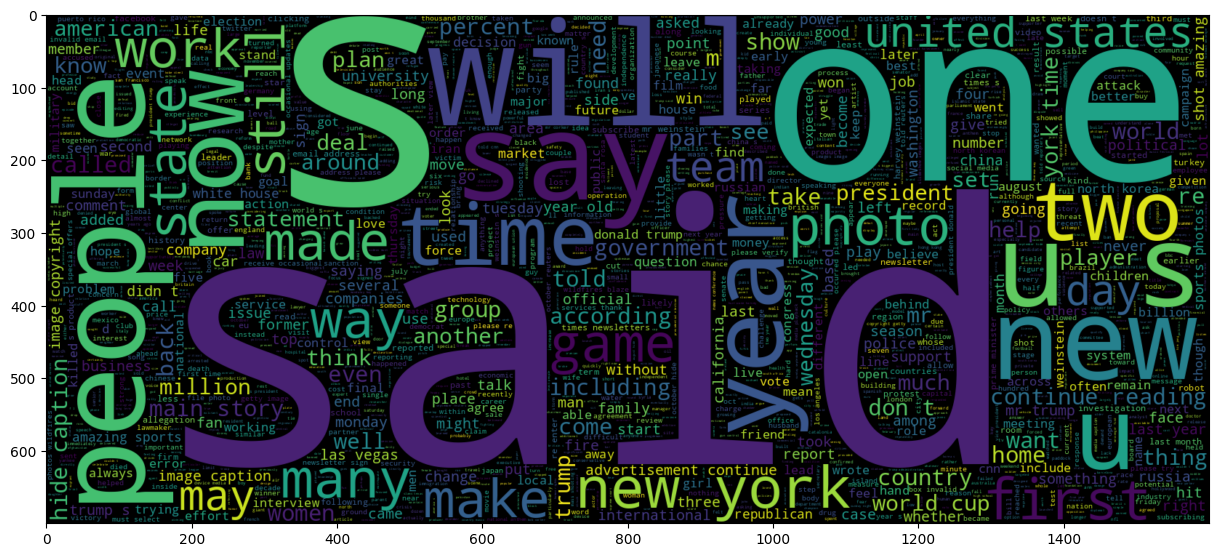

In [39]:
#word used in Real news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset5[Dataset5.label== 1].Article))
plt.imshow(wc, interpolation="bilinear")

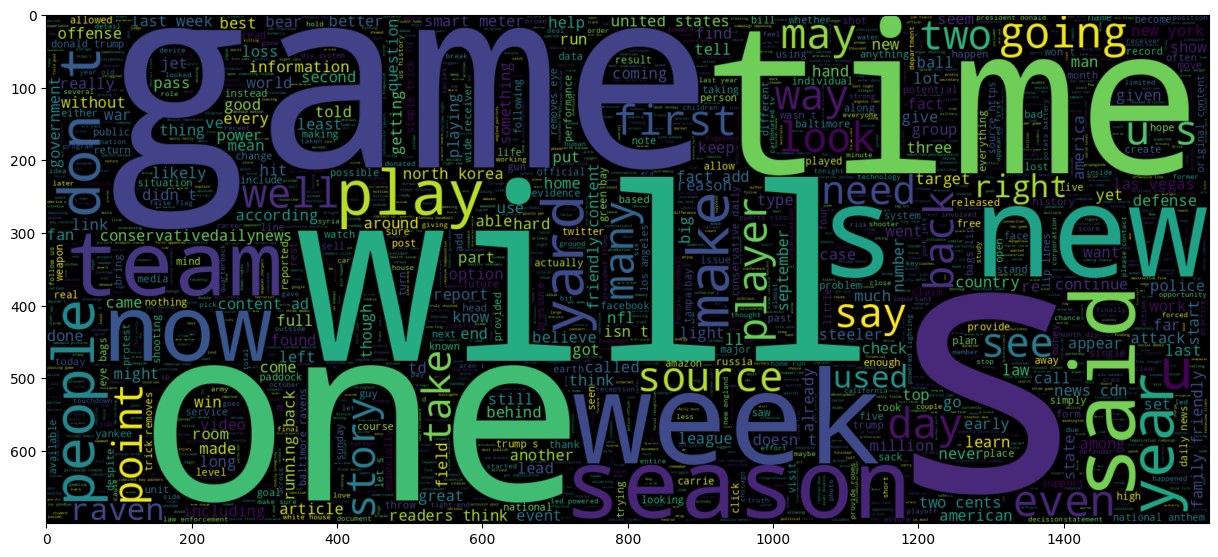

In [40]:
#word used in Real news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(Dataset5[Dataset5.label== 0].Article))
plt.imshow(wc, interpolation="bilinear")

In [43]:
#combining all the datset into one
frames = [Dataset2, Dataset3, Dataset4,Dataset5]
Dataset = pd.concat(frames)

In [44]:
Dataset.shape

(70145, 2)

In [45]:
x_train,x_test,y_train,y_test = train_test_split(Dataset['Article'], Dataset['label'], test_size=0.2, random_state=2020)

In [46]:
x_train.shape

(56116,)

In [47]:
x_test.shape

(14029,)

In [48]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression
from sklearn.metrics import accuracy_score

# Example usage (assuming x_train, y_train, x_test, y_test are already defined)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

Logisticmodel = pipe.fit(x_train, y_train)
prediction = Logisticmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
Logisticmodel_accuracy = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 91.52%


In [50]:
#####DecisionTreeClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 10,
                                           splitter='best',
                                           random_state=2020))])
DecisionTreemodel = pipe.fit(x_train, y_train)
prediction = DecisionTreemodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
DecisionTreemodel_accuracy = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 86.98%


In [ ]:
#####RandomForestClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])

RandomForestmodel = pipe.fit(x_train, y_train)
prediction = RandomForestmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
RandomForestmodel_accuracy = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
#Stochastic Gradient Descent
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', SGDClassifier())])
SGDmodel = pipe.fit(x_train, y_train)
prediction = SGDmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
SDGmodel_accuracy = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', GradientBoostingClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=55))])

GBCmodel = pipe.fit(x_train, y_train)
prediction = GBCmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
GBCmodel_accuracy = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
#########XGBClassifier
from xgboost import XGBClassifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', XGBClassifier(loss = 'deviance',
                                                   learning_rate = 0.01,
                                                   n_estimators = 10,
                                                   max_depth = 5,
                                                   random_state=2020))])

xgboostmodel = pipe.fit(x_train, y_train)
prediction = xgboostmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
xgboostmodel_accuracy = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
#######Multinomial Naive Bayes Classifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

MNBCmodel = pipe.fit(x_train, y_train)
prediction = MNBCmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
Multinomial_Naive_Bayes_accuracy = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
#############Bernoulli Naive Bayes Classifier
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', BernoulliNB())])

BNBCmodel = pipe.fit(x_train, y_train)
prediction = BNBCmodel.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
Bernoulli_Naive_Bayes_accuracy = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
x = ["SDGmodel_accuracy", "Logisticmodel_accuracy", "GBCmodel_accuracy", "xgboostmodel_accuracy" ,
     "DecisionTreemodel_accuracy","RandomForestmodel_accuracy","Multinomial_Naive_Bayes_accuracy",
     "Bernoulli_Naive_Bayes_accuracy"]
y =  [SDGmodel_accuracy,Logisticmodel_accuracy,GBCmodel_accuracy,xgboostmodel_accuracy,
      DecisionTreemodel_accuracy,RandomForestmodel_accuracy,Multinomial_Naive_Bayes_accuracy,
      Bernoulli_Naive_Bayes_accuracy]
plt.barh(x, y)

for index, value in enumerate(y):
    plt.text(value, index, str(value))

In [ ]:
import joblib
# Save the model as a pickle in a file
joblib.dump(Logisticmodel, 'model.pkl')